# TabNet regression example for Online News Popularity dataset

This notebook shows 
  - a simple workflow using TabNet for regression, [UCI ML repo](https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)
  - how to get global feature importances from the model
  - how to show local feature importances (masks) from the model
  - a comparison to XGBoost and LightGBM


In [1]:
try:
  from pytorch_tabnet.tab_model import TabNetRegressor
except:
  !pip install pytorch-tabnet
  from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
try:
  import wget
except:
  !pip install wget
  import wget

In [3]:
import torch; print('torch: ', torch.__version__)

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import pandas as pd; print('pandas:', pd.__version__)
import numpy as np

import os
import shutil
import zipfile
from pprint import PrettyPrinter
pprint = PrettyPrinter(compact=True).pprint

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

import psutil
print('CPU count:', psutil.cpu_count())

torch:  1.5.1+cu101
pandas: 1.0.5
CPU count: 2


# Download dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip"
dataset_name = 'online-news-popularity'

tmp_out = Path('data/'+dataset_name+'.zip')
out = Path('data/')

out.mkdir(parents=True, exist_ok=True)

In [5]:
print("Downloading file as", tmp_out, "...")
wget.download(url, tmp_out.as_posix())

'data/online-news-popularity (1).zip'

In [6]:
print("Extracting data to", out)
with zipfile.ZipFile(tmp_out, 'r') as zip_ref:
  zip_ref.extractall(out)

Extracting data to data


In [7]:
os.listdir('data/OnlineNewsPopularity')

['OnlineNewsPopularity.names', 'OnlineNewsPopularity.csv']

# Load data and split

In [8]:
df = pd.read_csv('data/OnlineNewsPopularity/OnlineNewsPopularity.csv')
print('loaded data with shape:', df.shape)

loaded data with shape: (39644, 61)


In [9]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [10]:
columns = pd.DataFrame({'column':df.columns})
columns['dtype']   = df.dtypes.values
columns['nunique'] = df.nunique().values
columns['missing'] = df.isnull().sum().values
columns

,column,dtype,nunique,missing
0,url,object,39644,0
1,timedelta,float64,724,0
2,n_tokens_title,float64,20,0
3,n_tokens_content,float64,2406,0
4,n_unique_tokens,float64,27281,0
...,...,...,...,...
56,title_subjectivity,float64,673,0
57,title_sentiment_polarity,float64,813,0
58,abs_title_subjectivity,float64,532,0
59,abs_title_sentiment_polarity,float64,653,0


In [11]:
columns_clean = [c.replace(' ', '') for c in df.columns]
df.columns = columns_clean

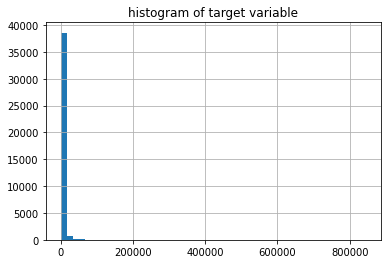

In [12]:
# target has very long tail and can benefit from a logarithm transformation
df['shares_log1p'] = np.log1p(df['shares'])

target = 'shares'
target_log1p = 'shares_log1p'
df[target].hist(bins=50)
plt.title('histogram of target variable');


Text(0.5, 1.0, 'histogram of log-transformed target variable')

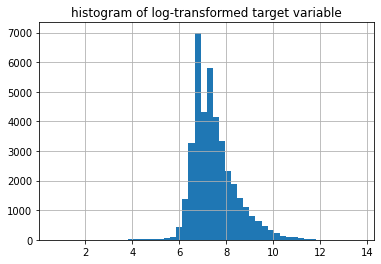

In [13]:
df['shares_log1p'].hist(bins=50)
plt.title('histogram of log-transformed target variable')

In [14]:
np.random.seed(42)

if "set" not in df.columns:
    df["set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df["set"]=="train"].index
valid_indices = df[df["set"]=="valid"].index
test_indices  = df[df["set"]=="test" ].index

# Features

There is no missing data and all features are continous already.

In [15]:
exclude = ['shares', 'shares_log1p', 'set']

In [16]:
def get_categorical_columns(df, exclude:list, max_nunique=200) -> list:
  "get a list of categorical columns, either type object or fewer than max_nunique values"
  
  columns_catg = [c for c in df.drop(exclude, axis=1).columns 
                  if (df[c].nunique()<max_nunique
                      or df[c].dtype=='object') 
                  and df[c].nunique()>2
                  and c.endswith('__label')==False
                  ]
  return columns_catg


def get_categorical_features(df) -> list:
  "get list of numerical categorical features"
  feats_catg = [c for c in df.columns if c.endswith('__label')]
  return feats_catg

In [17]:
columns_catg = get_categorical_columns(df, exclude, max_nunique=200)
print('categorical columns:')
pprint(columns_catg)

categorical columns:
['url', 'n_tokens_title', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
 'num_videos', 'num_keywords', 'kw_min_min', 'kw_max_max',
 'min_positive_polarity', 'max_positive_polarity', 'min_negative_polarity',
 'max_negative_polarity']


In [18]:
  # create new label encoded categorical columns
  for col in columns_catg:
    df[col] = df[col].fillna("00_MISSING")
    df[col+'__label'] = LabelEncoder().fit_transform(df[col].values)


features_catg = get_categorical_features(df)
print('categorical features:')
pprint(features_catg)

categorical features:
['url__label', 'n_tokens_title__label', 'num_hrefs__label',
 'num_self_hrefs__label', 'num_imgs__label', 'num_videos__label',
 'num_keywords__label', 'kw_min_min__label', 'kw_max_max__label',
 'min_positive_polarity__label', 'max_positive_polarity__label',
 'min_negative_polarity__label', 'max_negative_polarity__label']


In [19]:
features_all = [col for col in df.select_dtypes('number').columns
                if col not in exclude]

print(len(features_all), 'features:')
pprint(features_all)

features_catg_idxs = [i for i, f in enumerate(features_all) if f in features_catg]
print('\ncatg idxs:', features_catg_idxs)

72 features:
['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs',
 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
 'data_channel_is_lifestyle', 'data_channel_is_entertainment',
 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01',
 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
 'global_sentiment_polarity', 'global_rate_positive_words',
 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words',
 'avg_p

# Splits

In [20]:
X_train = df[features_all].values[train_indices]
y_train = df[target_log1p].values[train_indices]

X_valid = df[features_all].values[valid_indices]
y_valid = df[target_log1p].values[valid_indices]

X_test = df[features_all].values[test_indices]
y_test = df[target_log1p].values[test_indices]

print('train:', X_train.shape, '| valid:', X_valid.shape, '| test:', X_test.shape)

train: (31765, 72) | valid: (3931, 72) | test: (3948, 72)


# TabNet

In [21]:
def get_categorical_dims(df, features_catg) -> list:
  "get list ov dimensions for each categorical column"
  return list(df[features_catg].nunique().values)


def get_embedding_dims(df, features_catg, method='ln'):
  """
  Calculate dimensions for embeddings per feature. Larger dims can learn more but require longer training.
  Method:
  - int for same size for all features
  - 'sqrt' for square root of category counts
  - 'ln' for logn of category counts
  - 'fastai' for fastai sizes
  """

  emb_dims = []

  for f in features_catg:
    n_unique = df[f].nunique()
    
    if type(method)==int:  emb_dims.append( method )
    elif method=='sqrt':   emb_dims.append( int(np.sqrt(n_unique)) )
    elif method=='ln':     emb_dims.append( max(int(np.log(n_unique)), 1) )
    elif method=='fastai': emb_dims.append( min(600, round(1.6 * n_unique**0.56)) )

  return emb_dims

In [22]:
cat_dims = get_categorical_dims(df, features_catg)
print('cat dims:    ', cat_dims)

cat_emb_dim = get_embedding_dims(df, features_catg, method='ln')
print('cat emb dims:', cat_emb_dim)

cat dims:     [39644, 20, 133, 59, 91, 53, 10, 26, 35, 33, 38, 54, 49]
cat emb dims: [10, 2, 4, 4, 4, 3, 2, 3, 3, 3, 3, 3, 3]


In [23]:
# create estimator, default values
est = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                      cat_idxs=features_catg_idxs,
                      cat_dims=cat_dims,
                      cat_emb_dim=cat_emb_dim,
                      scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      scheduler_params={"gamma": 0.5, "step_size": 3},
                      )

Device used : cpu


## Training

In [24]:
# default values, takes about 220s on a 2 core CPU
est.fit(  
    X_train=X_train, y_train=y_train.reshape(-1, 1),
    X_valid=X_valid, y_valid=y_valid.reshape(-1, 1),
    max_epochs=100 , patience=10, 
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Will train until validation stopping metric hasn't improved in 10 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -55.49794 |  -31.07997 |   5.8       
| 2     | -11.49974 |  -1.30104 |   11.7      
| 3     | -0.96052 |  -0.95259 |   17.6      
| 4     | -0.87929 |  -0.89692 |   23.4      
| 5     | -0.86048 |  -0.85457 |   29.2      
| 6     | -0.85580 |  -0.85288 |   34.9      
| 7     | -0.84560 |  -0.84099 |   40.6      
| 8     | -0.83680 |  -0.83710 |   46.3      
| 9     | -0.83647 |  -0.83317 |   51.9      
| 10    | -0.83105 |  -0.83143 |   57.6      
| 11    | -0.82839 |  -0.82843 |   63.3      
| 12    | -0.82542 |  -0.82722 |   68.9      
| 13    | -0.82195 |  -0.82738 |   74.7      
| 14    | -0.81844 |  -0.82421 |   80.3      
| 15    | -0.81783 |  -0.82129 |   86.0      
| 16    | -0.81547 |  -0.82344 |   91.6      
| 17    | -0.81372 |  -0.82162 |   97.4      
| 18    | -0.81295 |  -0.82164 |   103.2     
| 19    |

In [25]:
print(f'best score: {est.best_cost:.4f}')

best score: 0.8206


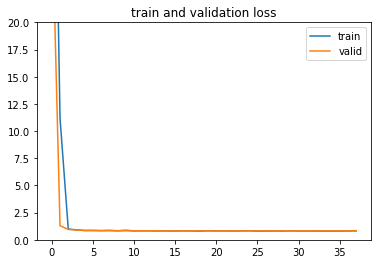

In [26]:
# plot losses
plt.plot(est.history['train']['loss'], label='train')
plt.plot(est.history['valid']['loss'], label='valid')
plt.title('train and validation loss');
plt.ylim(0, 20)
plt.legend();

## Predictions

In [27]:
tabnet_preds_test = est.predict(X_test)
tabnet_test_mse = metrics.mean_squared_error(y_true=y_test, y_pred=tabnet_preds_test)

print(f"valid MSE: {est.best_cost:.4f}")
print(f"test  MSE: {tabnet_test_mse:.4f}")

valid MSE: 0.8206
test  MSE: 0.7767


## Global explainability: feat importance summing to 1

In [28]:
feat_imp = (pd.DataFrame({'feature':features_all,
                          'importance':np.round(est.feature_importances_, 4)})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
)
feat_imp.style.bar()

,feature,importance
0,max_positive_polarity__label,0.390000
1,data_channel_is_world,0.073100
2,max_negative_polarity__label,0.060800
3,num_self_hrefs,0.055600
4,kw_min_min,0.055200
5,rate_negative_words,0.053500
6,num_self_hrefs__label,0.049600
7,is_weekend,0.041800
8,weekday_is_sunday,0.040400
9,kw_min_max,0.038200


## Local explainability and masks

In [29]:
explain_matrix, masks = est.explain(X_test)

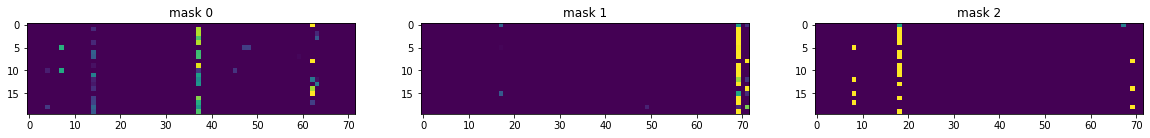

In [30]:
# shows masks per feature for first 20 rows
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:20])
    axs[i].set_title(f"mask {i}")

# Comparison to XGBoost and LightGBM

## XGBoost

In [31]:
from xgboost import XGBRegressor

In [32]:
%%time
# create XGB Regressor with slightly adjusted values (defaults are underfitting too much)
# takes about 30s
est_xgb = XGBRegressor( 
    max_depth=7, 
    n_estimators=5000,
    n_jobs=-1,
    learning_rate=0.03,
    subsample=0.7
    )

est_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric=['rmse'],
            early_stopping_rounds=10,
            verbose=25);

[13:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.81047
Will train until validation_0-rmse hasn't improved in 10 rounds.
[25]	validation_0-rmse:3.26647
[50]	validation_0-rmse:1.69954
[75]	validation_0-rmse:1.08885
[100]	validation_0-rmse:0.902
[125]	validation_0-rmse:0.854156
[150]	validation_0-rmse:0.842394
[175]	validation_0-rmse:0.838972
[200]	validation_0-rmse:0.83831
[225]	validation_0-rmse:0.83773
[250]	validation_0-rmse:0.83716
[275]	validation_0-rmse:0.836112
[300]	validation_0-rmse:0.83519
[325]	validation_0-rmse:0.834612
Stopping. Best iteration:
[336]	validation_0-rmse:0.834343

CPU times: user 1min 14s, sys: 96.9 ms, total: 1min 14s
Wall time: 1min 14s


In [33]:
xgb_preds_test = est_xgb.predict(X_test)
xgb_test_mse = metrics.mean_squared_error(y_true=y_test, y_pred=xgb_preds_test)
print(f'XGBoost MSE: {xgb_test_mse:.4f}')

XGBoost MSE: 0.6701


## LightGBM

In [34]:
from lightgbm import LGBMRegressor

In [35]:
%%time
# LightGBM Regressor with similar parameters to XGBoost
# takes about 5s
est_lgb = LGBMRegressor(num_leaves=2**8-1,
                        max_depth=7,
                        learning_rate=0.03,
                        n_estimators=5000,
                        subsample=0.7,
                        random_stage=42)

est_lgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric=['mse'],
            early_stopping_rounds=10,
            verbose=100);

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's l2: 0.708383	valid_0's l2: 0.708383
[200]	valid_0's l2: 0.697581	valid_0's l2: 0.697581
Early stopping, best iteration is:
[254]	valid_0's l2: 0.694702	valid_0's l2: 0.694702
CPU times: user 7.47 s, sys: 70.9 ms, total: 7.54 s
Wall time: 7.55 s


In [36]:
lgb_preds_test = est_lgb.predict(X_test)
lgb_test_mse = metrics.mean_squared_error(y_true=y_test, y_pred=lgb_preds_test)
print(f'LightGBM MSE: {lgb_test_mse:.4f}')

LightGBM MSE: 0.6732


## all scores and feature importances

In [37]:
print('test set scores:')
print(f'TabNet:   {tabnet_test_mse:.4f}')
print(f'XGBoost:  {xgb_test_mse:.4f}')
print(f'LightGBM: {lgb_test_mse:.4f}')

test set scores:
TabNet:   0.7767
XGBoost:  0.6701
LightGBM: 0.6732


On this dataset, XGBoost and LightGBM score a lot better than TabNet.

TabNet seems to get stuck in a local minima and needs additional parameter tuning.

In [38]:
feat_imp = (pd.DataFrame({ 'feature':features_all
                          ,'importance_tabnet':np.round(est.feature_importances_, 4)
                          ,'importance_xgb':   np.round(est_xgb.feature_importances_, 4)
                          ,'importance_lgb':   np.round(est_lgb.feature_importances_, 4)
                         })
            #.sort_values('importance_tabnet', ascending=False)
            .reset_index(drop=True)
)

# LGBM feature importances sum to 1
feat_imp['importance_lgb'] = feat_imp['importance_lgb']/feat_imp['importance_lgb'].sum()

feat_imp.style.bar()

,feature,importance_tabnet,importance_xgb,importance_lgb
0,timedelta,0.000000,0.005700,0.039560
1,n_tokens_title,0.000000,0.007900,0.015925
2,n_tokens_content,0.000000,0.010600,0.021149
3,n_unique_tokens,0.000000,0.014400,0.024852
4,n_non_stop_words,0.000700,0.000000,0.016179
5,n_non_stop_unique_tokens,0.000000,0.013000,0.028706
6,num_hrefs,0.000000,0.015500,0.035908
7,num_self_hrefs,0.055600,0.013500,0.016940
8,num_imgs,0.026500,0.015900,0.021251
9,num_videos,0.000300,0.017300,0.013795
